## ECS171 HW3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix

In [2]:
import scipy.stats as ss
from scipy import interp

In [3]:
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

The dataset contains 194 samples with 4502 featuers. The first 6 corresponding to gene ID, strain, medium, environmental perturbation (stresses present in the environment), gene perturbation, and growth rate. The rest corresponding to the expression of all genes in the bacterium. 

The dataset does not contain missing values except for the feature gene expression of b4635. There are only 114 samples have valid values for the feature b4635.

In [5]:
data = pd.read_csv('G:/ecs171/hw3/2019_ECS_171_HW3_Files/ecs171.dataset.txt', sep = '\s+')

In [6]:
data.shape

(194, 4502)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 4502 entries, ID to b4635
dtypes: float64(4435), int64(61), object(6)
memory usage: 6.7+ MB


In [9]:
check = data.isna().any()
check[check == True]

b4635    True
dtype: bool

In [10]:
sum(data.iloc[:,4501].str.isdigit() == True)

114

### P1. Predict the bacterial growth

Lasso is a linear regression model that attempt to minimize RSS with the $l_1$ penalty added. The penalty is a tuning hyperparameter multiplied by the sum of the abosolute value of all coefficients. Lasso would shrink the model for that it prefer solution with fewer non-zero coefficients, which makes the model more interpretable.

The formula is presented as below:

$RSS = \sum_{i=1}^n(y_i-\hat y_i)^2$

$\frac{1}{2n}RSS + \alpha\sum_{j=1}^p|\hat\beta_j|,$

where n is the number of observations, p is the number of features, $\beta_j$ is the coefficient of the jth of p features, and $\alpha$ is the tuning hyperparameter.

Considering that the dataset has only 194 samples, but more than 4000 features, I choose Lasso to shrink the model. 

Lasso was used to predict the bacterial growth(y). 

Pipeline was used for the standardization of expression of the genes(X). 

I use randomized search to find out the optimal parameter value by 5-fold cross-validation. The parameter was randomly sample with replacement from uniform distribution U\[0.01, 2\] for 1000 times. According to the randomized search results, the optimal parameter is 0.01459365815622359. 

Then I use the optimal parameter to retrain the Lasso model. The Lasso model have 59 non-zero coefficients, and the mean MSE of 5-fold cross-validation is 0.045294909677612676.

In [11]:
X = data.iloc[:,6:4501]

In [12]:
y = data['GrowthRate']

In [13]:
pipe = Pipeline([('std', StandardScaler()),('regr', Lasso())])

search_space = {'regr':[Lasso()], 'std':[StandardScaler(), None], 'regr__alpha':ss.uniform(0.01,2)}

rs = RandomizedSearchCV(pipe, param_distributions=search_space , cv=5, scoring='neg_mean_squared_error',random_state=1, n_iter=1000, n_jobs=-1)

best_model = rs.fit(X,y)

In [14]:
alpha_best = best_model.best_params_['regr__alpha']

In [15]:
regr_best = Lasso(alpha=alpha_best)

In [16]:
std = StandardScaler()
X_std = std.fit_transform(X)

In [17]:
regr_best.fit(X_std,y)

Lasso(alpha=0.01459365815622359, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
print('Number of features:', sum(regr_best.coef_!=0))

Number of features: 59


In [19]:
pipe2 = Pipeline([('std', StandardScaler()),('regr', Lasso(alpha = alpha_best))])

In [20]:
print('Generalization error:', -cross_val_score(pipe2, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean())

Generalization error: 0.045294909677612676


### P2. Confidence interval of the prediction

Bootstrap method was used to produce the confidence interval of the predicition.

Bootstrap is a resampling method to estimate a population parameter $\theta$. Given a sample dataset with size n, we could draw a sample from the original sample dataset with replacement, and replicate B times. For each bootstrap sample i, we could get a statistic to estimate the parameter, denote as $\theta_i^*$. 

By the Central Limit Theorem, the resampling distribution of the differnce in means approaches a normal distribution when B is large. 

Assuming that these B statistics follow a t-distribution, we could then get a 100(1-$\alpha$)% confidence interval for the estimate $\hat{\theta}$:

$(\bar{\theta^*} \pm t_{(1-\alpha/2, B-1)} * std(\theta^*)$)

In [21]:
def bootstrap(B, newdata, n):
    """ Bootstrap function to report the confidence interval of the predicition

    Args:
        param1: The number of resampling times.
        param2: The data to be predicted.
        param3: The sample size of the original dataset.
        
    Returns:
        The lower bound and the upper bound of the 95% confidence interval.

    """
    pred = []
    for i in range(B):
        samp = np.random.choice(194, size = n)
        sub_X = data.iloc[samp, 6:4501]
        sub_y = data.iloc[samp, 5]
        
        pipe2.fit(sub_X, sub_y)
        pred.append(pipe2.predict(newdata))
    
    pred = np.array(pred)
    qt = ss.t.ppf(q = 0.975, df = B)
    
    LB = pred.mean() - qt * pred.std(ddof = 1)
    UB = pred.mean() + qt * pred.std(ddof = 1)
    
    return (LB, UB)

### P3. Confidence interval of the prediction for a specific bacterium

To find the confidence interval of predicted growth for a bacterium whose genes are expressed exactly at the mean expression value. 

Here I set the number of bootstrap sampels(B) to 1000.

In [22]:
newdata = data.iloc[:, 6:4501].mean(axis = 0)
newdata = np.array(newdata).reshape(1,-1)

In [23]:
B = 1000
print('95% C.I.:', bootstrap(B, newdata, len(data)))

95% C.I.: (0.3826273522089719, 0.4163851915581527)


### P4. SVM classifiers using feature selection

Four seperate SVM classifiers was created to categorize the strain type('Strain'), medium type('Medium'), environmental('Stress') and gene perturbation('GenePerturbed'). Here I only use features that have non-zero coefficients in the optimal Lasso model created in P1. So each classifier has the same 59 features.

The 5-fold cross-validation results were shown as below. Since we have imbalanced data, I use stratified K-fold to roughly keep the same percentage of observation from each of the different target classes in folds. 

In [24]:
none_zero = list(regr_best.coef_!=0)

In [25]:
none_zero_X = X.T[none_zero].T

In [26]:
def svm_cv(X, y, cv, name = '', plot_curve_ = False):   
    """ Create SVM classifier for multiclass dataset, report 10-fold cross-validation AUC/AUPRC.
        Plot roc curve and precision-recall curve if needed.

    Args:
        param1: Features
        param2: Target
        param3: Name of target
        param4: Whether to plot roc curve and precision-recall curve 
        
    Returns:
        Target in binarized form
        The decision function for the samples
        LabelBinarizer
        
    """
    lb = LabelBinarizer()
    binary_y = lb.fit_transform(y)
    
    n_classes = binary_y.shape[1]
    
    probas = np.zeros((binary_y.shape[0],binary_y.shape[1]))
    #pred = np.zeros((binary_y.shape[0],binary_y.shape[1]))
    
    cv_ = StratifiedKFold(n_splits = cv, random_state = 1)
    clf = OneVsRestClassifier(SVC(gamma = 'scale', probability=True, random_state= 12))
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    precision = {}
    recall = {}
    auprc = {}

    for train, test in cv_.split(X, y):
        clf.fit(X.iloc[train,], binary_y[train,:])
        probas[test,] = clf.decision_function(X.iloc[test,])
        #pred[test,] = clf.predict(X.iloc[test,])
        
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_y[:, i], probas[:, i])
        precision[i], recall[i], _ = precision_recall_curve(binary_y[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) 
        #auprc[i] = auc(recall[i], precision[i])
        auprc[i] = average_precision_score(binary_y[:, i], probas[:, i])
        
    fpr['micro'], tpr['micro'], _ = roc_curve(binary_y.ravel(), probas.ravel())
    precision['micro'], recall['micro'], _ = precision_recall_curve(binary_y.ravel(), probas.ravel())
    
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    #roc_auc['micro'] = roc_auc_score(binary_y, probas, average='micro')
    auprc['micro'] = auc(recall['micro'], precision['micro'])
    #auprc['micro'] = average_precision_score(binary_y, probas, average='micro')
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    mean_precision = np.zeros_like(all_recall)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_precision += interp(all_recall, precision[i], recall[i])
    mean_tpr /= n_classes
    mean_precision /= n_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    #roc_auc['macro'] = roc_auc_score(binary_y, probas, average='macro')
    
    recall['macro'] = all_recall
    precision['macro'] = mean_precision
    auprc['macro'] = auc(recall['macro'], precision['macro'])
    #auprc['macro'] = average_precision_score(binary_y, probas, average='macro')
    
    ### plot roc, precision-recall 
    if plot_curve_:
        plot_curve(fpr, tpr, roc_auc, precision, recall, auprc, name)
    
    return  binary_y, probas, lb
   

In [27]:
def plot_curve(fpr, tpr, roc_auc, precision, recall, auprc, name):
    """ Plot roc curve and precision-recall curve

    Args:
        param1: fpr
        param2: tpr
        param3: AUC
        param4: precision
        param5: recall
        param6: AUPRC
        param7: Name of target
        
     """
    plt.plot(fpr['micro'], tpr['micro'], label = 'micro-average ROC (AUC = %0.2f)' % roc_auc['micro'])
    plt.plot(fpr['macro'], tpr['macro'], label = 'macro-average ROC (AUC = %0.2f)' % roc_auc['macro'])
    plt.plot([0,1], [0,1], 'k--', lw = 2)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])        
    plt.title('Receiver operating characteristic for %s' % name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'best')
    plt.show()
    
    plt.plot(recall['micro'], precision['micro'], label = 'micro-average PRC (AUPRC = %0.2f)' % (auprc['micro']))
    plt.plot(recall['macro'], precision['macro'], label = 'macro-average PRC (AUPRC = %0.2f)' % (auprc['macro']))
        
    plt.title('Precission-Recall Curve for %s' % name)
    plt.ylabel('Precission')
    plt.xlabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc = 'best')
    plt.show()

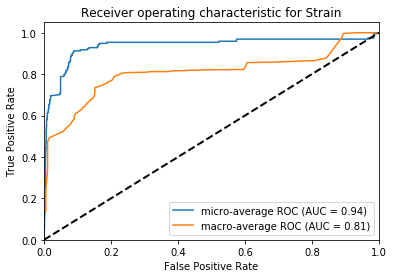

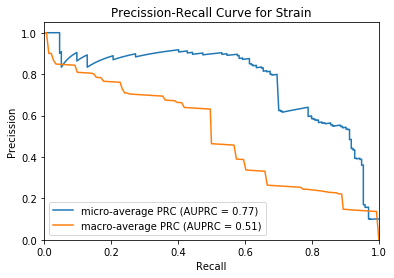

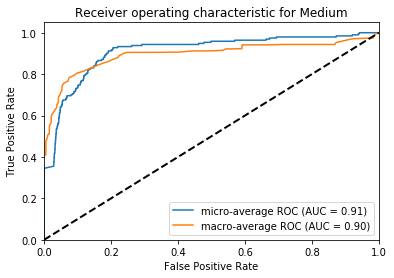

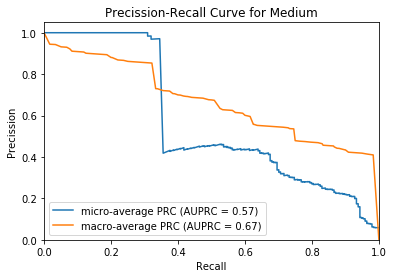

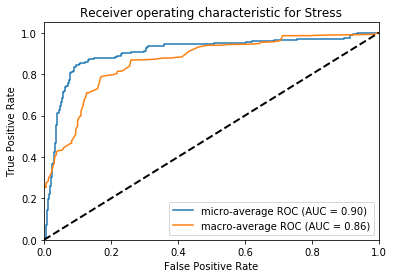

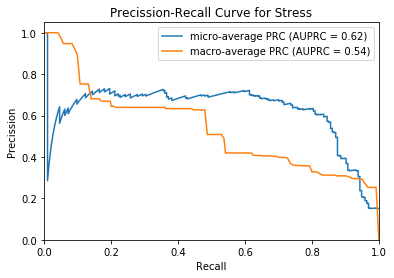

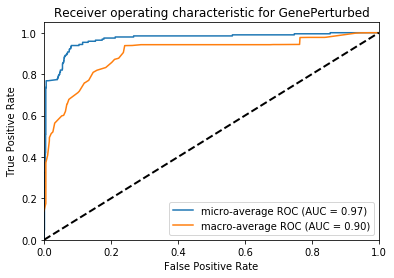

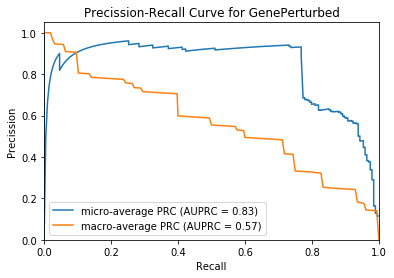

In [28]:
for i in range(4):
    svm_cv(none_zero_X, data.iloc[:,i+1], 5, data.columns[i+1], True)

### P5. Composite SVM classifier

A composite SVM classifier was created to simultaneouly predict medium('Medium') and environmental perturbations('Stress'). 

The composite SVM classifier was created by concatenating the label of 'Medium' and 'Stress', and make prediction of this new concatenated label. The number of samples in each category were shown in the table below.

In [29]:
data['Medium_Stress'] = data['Medium'] + '_' + data['Stress']

In [30]:
pd.DataFrame(data['Medium_Stress'].value_counts())

,Medium_Stress
MD001_none,36
MD001_O2-starvation,18
MD002_none,16
MD011_none,15
MD004_carbon-limitation,13
MD007_carbon-limitation,12
MD013_none,11
MD009_antibacterial,8
MD018_none,7
MD017_none,7


10-fold cross-validation AUC/AUPRC were used to measure the results.

To compare the composite classifer to the two individual classifiers in P4 together, I combine the two classifers' scores to get the scores for each concatenate label, and then get the overall AUC/AUPRC.

Also, I create a baseline classifier that always predict to 'MD001_none', the category that has the most samples.

The results were shown as below.

In [31]:
y = data['Medium_Stress']
y_true, y_score, lb_m_s = svm_cv(none_zero_X, y, 10)

In [32]:
num_m_s = y_true.shape[1]

In [33]:
def score_report(y_true, y_score):
    auc_micro = roc_auc_score(y_true, y_score, average='micro')
    auc_macro = roc_auc_score(y_true, y_score, average='macro')

    auprc_micro = average_precision_score(y_true, y_score, average='micro')
    auprc_macro = average_precision_score(y_true, y_score, average='macro')
    
    return auc_micro, auc_macro, auprc_micro, auprc_macro

In [34]:
result = {'Composite':[], 'Separate':[], 'Baseline':[]}

In [35]:
a,b,c,d = score_report(y_true, y_score)
result['Composite'].extend([a,b,c,d])

In [36]:
y_true_m, y_score_m, lb_m = svm_cv(none_zero_X, data['Medium'], 5)
y_true_s, y_score_s, lb_s = svm_cv(none_zero_X, data['Stress'], 5)

In [37]:
num_m = y_true_m.shape[1]
num_s = y_true_s.shape[1]

In [38]:
def compute_():    
    scores = np.zeros((len(data), num_m_s))
    
    for i in range(num_m_s):
        one_ = np.zeros((1,num_m_s))
        one_[0,i]=1
        l_m_s = lb_m_s.inverse_transform(one_)
        l_m, l_s = list(l_m_s)[0].split('_')
        
        ind_m = np.where(lb_m.transform(np.array([l_m]))==1)[1]
        ind_s = np.where(lb_s.transform(np.array([l_s]))==1)[1]
    
        scores[:,i] = np.add(y_score_m[:,ind_m], y_score_s[:,ind_s])[:,0]
    
    return scores

In [39]:
scores = compute_()
a,b,c,d = score_report(y_true, scores)
result['Separate'].extend([a,b,c,d])

In [40]:
p = lb_m_s.transform(np.array(['MD001_none']))
scores_baseline = np.repeat(p,len(data), axis=0)
a,b,c,d = score_report(y_true, scores_baseline)
result['Baseline'].extend([a,b,c,d])

In [41]:
pd.DataFrame(result, index=['micro AUC', 'macro AUC', 'micro AUPRC', 'macro AUPRC'])

,Composite,Separate,Baseline
micro AUC,0.907656,0.769876,0.574274
macro AUC,0.876690,0.736634,0.500000
micro AUPRC,0.517631,0.210359,0.069845
macro AUPRC,0.547771,0.336123,0.043478


It is shown that the composite SVM classifier performs better than the separate classifier together. Besides, both the composite SVM classifier and the separate classifier together perform better than the baseline classifier.

### P6. Reduce the dimensionality of gene expression profiles

PCA and t-SNE were used to reduce the dimension of gene expression profiles to 2 dimensions. The datasets after processing were visualized as below. 

In [42]:
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X_std)

In [43]:
X_embedded = TSNE(n_components=2).fit_transform(X_std)

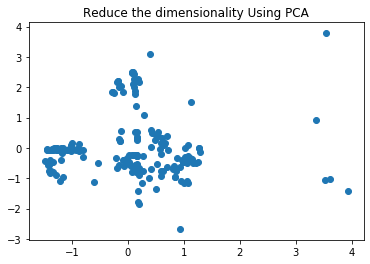

In [44]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('Reduce the dimensionality Using PCA')
plt.show()

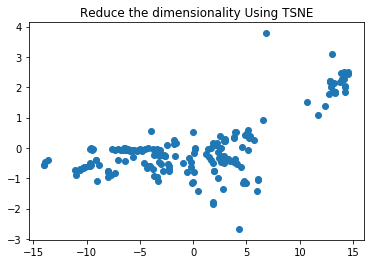

In [45]:
plt.scatter(X_embedded[:,0], X_pca[:,1])
plt.title('Reduce the dimensionality Using TSNE')
plt.show()

### P7. SVM classifiers using feature extraction

Retrain the 4 SVM classifiers in P4, using feature extraction results in P6.

The 10-fold cross-validation AUC/AUPRC values were shown as below.

In [46]:
c_PCA = np.zeros((4,4))
c_tSNE = np.zeros((4,4))
c_fs = np.zeros((4,4))

In [47]:
for i in range(4):
    y_true, y_score, _ = svm_cv(pd.DataFrame(X_pca), data.iloc[:,i+1], 10)
    a,b,c,d = score_report(y_true, y_score)
    c_PCA[i] = [a,b,c,d]

In [48]:
for i in range(4):
    y_true, y_score, _ = svm_cv(pd.DataFrame(X_embedded), data.iloc[:,i+1], 10)
    a,b,c,d = score_report(y_true, y_score)
    c_tSNE[i] = [a,b,c,d]

In [49]:
for i in range(4):
    y_true, y_score, _ = svm_cv(none_zero_X, data.iloc[:,i+1], 10)
    a,b,c,d = score_report(y_true, y_score)
    c_fs[i] = [a,b,c,d]

In [50]:
for i in range(4):
    result = np.vstack((c_PCA[i], c_tSNE[i], c_fs[i]))
    result= pd.DataFrame(result, columns=['micro AUC', 'macro AUC', 'micro AUPRC', 'macro AUPRC'],index=['PCA', 't-SNE','Feature Selection'])
    result.columns.name = data.columns[i+1]
    display(result)

Strain,micro AUC,macro AUC,micro AUPRC,macro AUPRC
PCA,0.919685,0.659589,0.715658,0.205932
t-SNE,0.954994,0.910976,0.794646,0.389159
Feature Selection,0.942270,0.813666,0.805962,0.473577


Medium,micro AUC,macro AUC,micro AUPRC,macro AUPRC
PCA,0.866364,0.856060,0.422697,0.376580
t-SNE,0.922619,0.910503,0.605903,0.594825
Feature Selection,0.934176,0.908869,0.639704,0.618050


Stress,micro AUC,macro AUC,micro AUPRC,macro AUPRC
PCA,0.899777,0.740113,0.735863,0.351707
t-SNE,0.912150,0.810894,0.735630,0.435143
Feature Selection,0.914762,0.872737,0.695295,0.539866


GenePerturbed,micro AUC,macro AUC,micro AUPRC,macro AUPRC
PCA,0.951695,0.840292,0.797840,0.256922
t-SNE,0.943869,0.873894,0.813930,0.232494
Feature Selection,0.973288,0.898041,0.842213,0.482355


According to the tables above, for the classifier of 'Strain', feature selection is the best pre-processing approach; for the classifier of 'Medium', feature selection is best pre-processing approach; for the classifier of 'Stress', t-SNE is the best pre-processing approach; for the classifier of 'GenePerturbed', feature selection is the best pre-processing approach.